# Forecasting Energy Demand 

## Modeling
My approach treats the problem as a standard supervised regression task. Given a set of features – the time and weather information – we want to build a model that can predict the continuous target, energy consumption. The model is trained on the past historical energy consumption using the features and the target and then can be used to make predictions for future dates where only the features are known.

* Train/Test Split
* Scale all features using a min-max scaler
* Fit data with model
* Evaluate model


In [ ]:
# Install xgboost in notebook instance
!conda install -y -c conda-forge xgboost

In [ ]:
# Install plotly in notebook instance
!conda install -c plotly plotly=4.4.1

In [1]:
# Import AWS and Sagemaker SDKs and get files access
import boto3
import io
from sagemaker import get_execution_role

role = get_execution_role()
bucket ='sagemaker-data-energy-demand'

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


# XGBoost 
import xgboost as xgb

In [3]:
# Import data 

CITY = 'LosAngeles'
train_key = 'dataframes/%s_reframed_train.csv' % CITY
validation_key = 'dataframes/%s_reframed_validation.csv' % CITY

train_location = 's3://{}/{}'.format(bucket, train_key)
validation_location = 's3://{}/{}'.format(bucket, validation_key)

df_train = pd.read_csv(train_location, index_col='datetime')
df_validation = pd.read_csv(validation_location, index_col='datetime')

In [4]:
df_validation.tail()

,demand(t),dailycoolingdegreedays(t-1),dailyheatingdegreedays(t-1),hourlydewpointtemperature(t-1),hourlydrybulbtemperature(t-1),hourlyprecipitation(t-1),hourlyrelativehumidity(t-1),hourlysealevelpressure(t-1),hourlystationpressure(t-1),hourlyvisibility(t-1),...,dayofweek(t),quarter(t),month(t),year(t),dayofyear(t),dayofmonth(t),weekofyear(t),isbusinessday(t),isholiday(t),daylight(t)
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-11 17:00:00+00:00,2777.0,0.0,0.0,45.0,57.0,0.0,64.0,30.05,29.70,10.0,...,5.0,1.0,1.0,2020.0,11.0,11.0,2.0,0.0,0.0,1.0
2020-01-11 18:00:00+00:00,2771.0,0.0,0.0,47.0,58.0,0.0,67.0,30.05,29.70,10.0,...,5.0,1.0,1.0,2020.0,11.0,11.0,2.0,0.0,0.0,0.0
2020-01-11 19:00:00+00:00,2734.0,0.0,0.0,47.0,56.0,0.0,72.0,30.06,29.71,10.0,...,5.0,1.0,1.0,2020.0,11.0,11.0,2.0,0.0,0.0,0.0
2020-01-11 20:00:00+00:00,2695.0,0.0,0.0,47.0,57.0,0.0,69.0,30.07,29.73,10.0,...,5.0,1.0,1.0,2020.0,11.0,11.0,2.0,0.0,0.0,0.0
2020-01-11 21:00:00+00:00,2635.0,0.0,0.0,47.0,57.0,0.0,69.0,30.07,29.72,10.0,...,5.0,1.0,1.0,2020.0,11.0,11.0,2.0,0.0,0.0,0.0


In [ ]:
plot_train = pd.DataFrame(df_train['demand(t)'])
plot_validation = pd.DataFrame(df_validation['demand(t)'])
plot_train.index = df_train.index
plot_validation.index = df_validation.index

to_plot = plot_validation \
    .rename(columns={'demand(t)': 'VALIDATION SET'}) \
    .join(plot_train.rename(columns={'demand(t)': 'TRAINING SET'}), how='outer') \


# Create traces
fig = go.Figure()
fig.add_trace(go.Scattergl(y=to_plot['TRAINING SET'], x=to_plot.index,
                    mode='lines',
                    name='TRAINING SET'))
fig.add_trace(go.Scattergl(y=to_plot['VALIDATION SET'], x=to_plot.index,
                    mode='lines',
                    name='VALIDATION SET',
                    marker_color='rgb(0, 204, 150)'))
fig.update_layout(title='Los Angeles - Train/Validation Split',
                   xaxis_title='Date',
                   yaxis_title='Electricity Demand [MWh]')
fig.show()

In [5]:
def data_sppliter(df, label):
    cols = list(df.columns)
    cols.remove(label)
    X = df[cols]
    y = df[label]
    return X, y

X_train, y_train = data_sppliter(df_train, label='demand(t)')
X_validation, y_validation = data_sppliter(df_validation, label='demand(t)')

## Create XGBoost Model

In [6]:
# XGBoost Training Parameter Reference: 
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

regressor = xgb.XGBRegressor(max_depth=5, n_estimators=250)

In [7]:
regressor.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_validation, y_validation)]) 

[04:40:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2989.94	validation_1-rmse:2575.48
[1]	validation_0-rmse:2691.79	validation_1-rmse:2318.21
[2]	validation_0-rmse:2423.47	validation_1-rmse:2086.54
[3]	validation_0-rmse:2181.91	validation_1-rmse:1875.65
[4]	validation_0-rmse:1964.57	validation_1-rmse:1687.15
[5]	validation_0-rmse:1768.93	validation_1-rmse:1519.42
[6]	validation_0-rmse:1592.82	validation_1-rmse:1366.59
[7]	validation_0-rmse:1434.35	validation_1-rmse:1228.78
[8]	validation_0-rmse:1291.79	validation_1-rmse:1105.54
[9]	validation_0-rmse:1163.41	validation_1-rmse:995.204
[10]	validation_0-rmse:1047.89	validation_1-rmse:895.925
[11]	validation_0-rmse:943.928	validation_1-rmse:805.863
[12]	validation_0-rmse:850.359	validation_1-rmse:725.763
[13]	validation_0-rmse:766.228	validation_1-rmse:653.388
[14]	validation_0-rmse:690

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [8]:
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

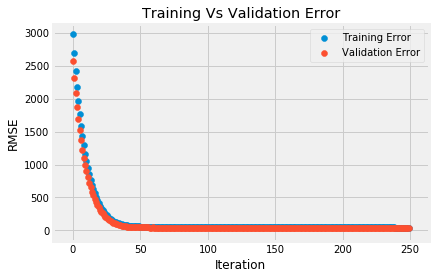

In [9]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

### Feature importance plot
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.
We can see that the hour was most commonly used to split trees alongside day of year and day of week, while weather features has low importance.

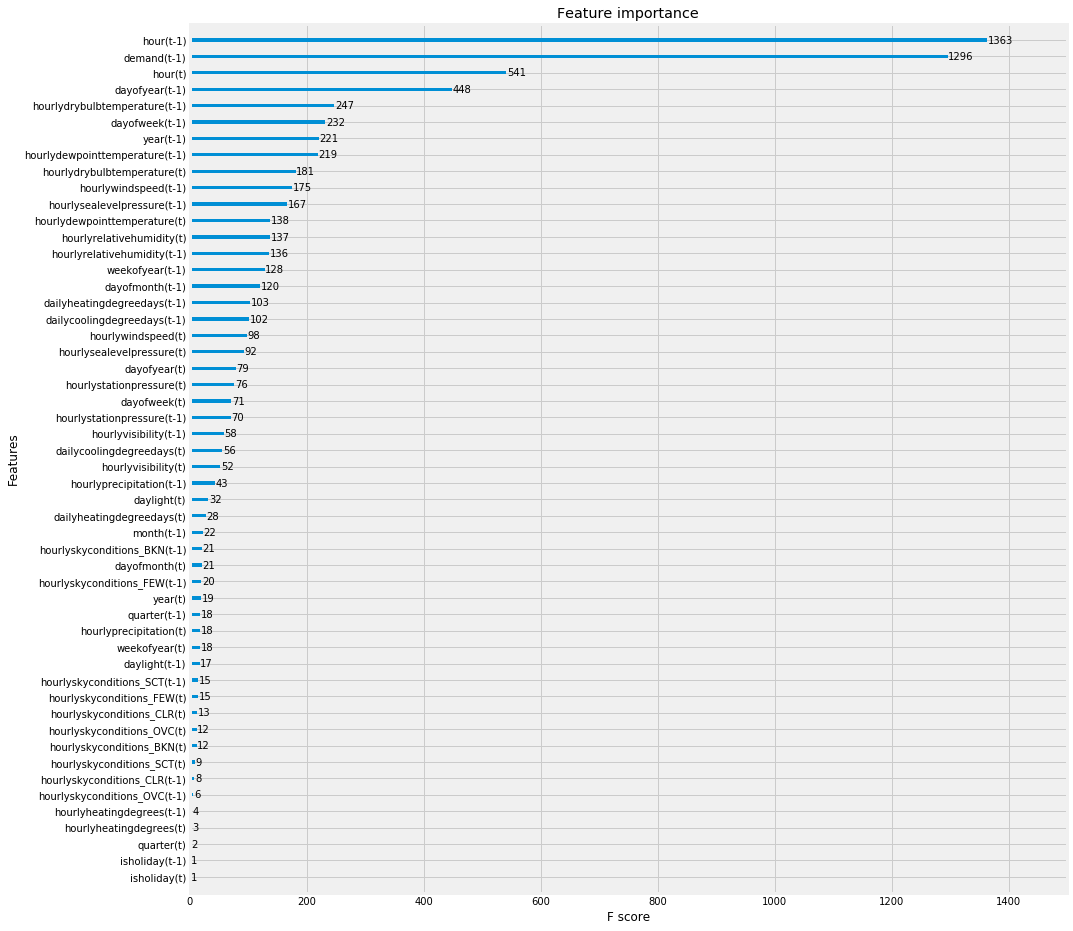

In [10]:
fig, ax = plt.subplots(figsize=(14, 16))
xgb.plot_importance(regressor, ax=ax)
plt.show()

## Forecast on Validation Set

In [11]:
df_validation['XGBoost_demand_prediction'] = regressor.predict(X_validation)
df_all = pd.concat([df_train, df_validation], sort=False)

In [12]:
regressor.score(X_validation, y_validation)

0.9911349614246326

In [13]:
df_validation.head()

,demand(t),dailycoolingdegreedays(t-1),dailyheatingdegreedays(t-1),hourlydewpointtemperature(t-1),hourlydrybulbtemperature(t-1),hourlyprecipitation(t-1),hourlyrelativehumidity(t-1),hourlysealevelpressure(t-1),hourlystationpressure(t-1),hourlyvisibility(t-1),...,quarter(t),month(t),year(t),dayofyear(t),dayofmonth(t),weekofyear(t),isbusinessday(t),isholiday(t),daylight(t),XGBoost_demand_prediction
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-09 21:00:00+00:00,2962.0,0.0,7.0,38.0,58.0,0.0,48.0,30.03,29.69,10.0,...,1.0,1.0,2020.0,9.0,9.0,2.0,1.0,0.0,0.0,2949.293213
2020-01-09 22:00:00+00:00,2982.0,0.0,7.0,36.0,56.0,0.0,47.0,30.06,29.71,10.0,...,1.0,1.0,2020.0,9.0,9.0,2.0,1.0,0.0,0.0,2950.262207
2020-01-09 23:00:00+00:00,2992.0,0.0,7.0,36.0,64.0,0.0,47.0,29.96,29.61,10.0,...,1.0,1.0,2020.0,10.0,10.0,2.0,1.0,0.0,0.0,2966.055420
2020-01-10 00:00:00+00:00,3082.0,0.0,9.0,33.0,56.0,0.0,42.0,30.08,29.74,10.0,...,1.0,1.0,2020.0,10.0,10.0,2.0,1.0,0.0,0.0,3096.118896
2020-01-10 01:00:00+00:00,3343.0,0.0,9.0,33.0,52.0,0.0,49.0,30.10,29.76,10.0,...,1.0,1.0,2020.0,10.0,10.0,2.0,1.0,0.0,0.0,3314.866211


In [14]:
df_all.tail()

,demand(t),dailycoolingdegreedays(t-1),dailyheatingdegreedays(t-1),hourlydewpointtemperature(t-1),hourlydrybulbtemperature(t-1),hourlyprecipitation(t-1),hourlyrelativehumidity(t-1),hourlysealevelpressure(t-1),hourlystationpressure(t-1),hourlyvisibility(t-1),...,quarter(t),month(t),year(t),dayofyear(t),dayofmonth(t),weekofyear(t),isbusinessday(t),isholiday(t),daylight(t),XGBoost_demand_prediction
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-11 17:00:00+00:00,2777.0,0.0,0.0,45.0,57.0,0.0,64.0,30.05,29.70,10.0,...,1.0,1.0,2020.0,11.0,11.0,2.0,0.0,0.0,1.0,2797.928711
2020-01-11 18:00:00+00:00,2771.0,0.0,0.0,47.0,58.0,0.0,67.0,30.05,29.70,10.0,...,1.0,1.0,2020.0,11.0,11.0,2.0,0.0,0.0,0.0,2788.651367
2020-01-11 19:00:00+00:00,2734.0,0.0,0.0,47.0,56.0,0.0,72.0,30.06,29.71,10.0,...,1.0,1.0,2020.0,11.0,11.0,2.0,0.0,0.0,0.0,2771.863281
2020-01-11 20:00:00+00:00,2695.0,0.0,0.0,47.0,57.0,0.0,69.0,30.07,29.73,10.0,...,1.0,1.0,2020.0,11.0,11.0,2.0,0.0,0.0,0.0,2725.415039
2020-01-11 21:00:00+00:00,2635.0,0.0,0.0,47.0,57.0,0.0,69.0,30.07,29.72,10.0,...,1.0,1.0,2020.0,11.0,11.0,2.0,0.0,0.0,0.0,2707.069336


In [ ]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scattergl(y=df_all['demand(t)'], x=df_all.index,
                    mode='markers',
                    name='TRAINING SET'))
fig.add_trace(go.Scattergl(y=df_all['XGBoost_demand_prediction'], x=df_all.index,
                    mode='lines',
                    name='PREDICT SET'))
fig.update_layout(title='Los Angeles - Forecast On Test',
                   xaxis_title='Date',
                   yaxis_title='Electricity Demand [MWh]')
fig.show()

### Zooming-in at first month of predictions

In [ ]:
# Create traces
first_month = df_all.head(720)
fig = go.Figure()
fig.add_trace(go.Scattergl(y=first_month['demand(t)'], x=first_month.index,
                    mode='lines',
                    name='TRAINING SET'))
fig.add_trace(go.Scattergl(y=first_month['XGBoost_demand_prediction'], x=first_month.index,
                    mode='lines',
                    name='TEST SET'))
fig.update_layout(title='Forecast vs Actuals - First Month',
                   xaxis_title='Date',
                   yaxis_title='Electricity Demand [MWh]')
fig.show()

In [ ]:
# Create traces
first_month = df_all.head(168)
fig = go.Figure()
fig.add_trace(go.Scattergl(y=first_month['demand(t)'], x=first_month.index,
                    mode='markers',
                    name='TEST SET'))
fig.add_trace(go.Scattergl(y=first_month['XGBoost_demand_prediction'], x=first_month.index,
                    mode='lines',
                    name='PREDICT SET'))
fig.update_layout(title='Forecast vs Actuals - First Month',
                   xaxis_title='Date',
                   yaxis_title='Electricity Demand [MWh]')
fig.show()

In [ ]:
df_all.tail()

### Error Metrics On Test Set

In [15]:
rmse = mean_squared_error(y_true=df_validation['demand(t)'],
                   y_pred=df_validation['XGBoost_demand_prediction'])

mae = mean_absolute_error(y_true=df_validation['demand(t)'],
                   y_pred=df_validation['XGBoost_demand_prediction'])

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true=df_validation['demand(t)'],
                   y_pred=df_validation['XGBoost_demand_prediction'])

print(rmse)
print(mae)
print(mape)

808.1086119133599
21.570795798788264
0.7404197392274428


### Look at Worst and Best Predicted Days

In [16]:
df_validation['error'] = df_validation['demand(t)'] - df_validation['XGBoost_demand_prediction']
df_validation['abs_error'] = df_validation['error'].apply(np.abs)
error_by_day = df_validation.groupby(['year(t)','month(t)','dayofmonth(t)']) \
    .mean()[['demand(t)','XGBoost_demand_prediction','error','abs_error']]

In [17]:
# Worst predicted days
error_by_day.sort_values('error', ascending=True).head(10)

demand(t)  XGBoost_demand_prediction  \
year(t) month(t) dayofmonth(t)                                           
2020.0  1.0      11.0           2772.173913                2780.486084   
                 10.0           2907.750000                2910.634277   
                 9.0            2972.000000                2949.777832   

                                    error  abs_error  
year(t) month(t) dayofmonth(t)                        
2020.0  1.0      11.0           -8.312160  23.421005  
                 10.0           -2.884359  19.743388  
                 9.0            22.222290  22.222290

In [18]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

demand(t)  XGBoost_demand_prediction  \
year(t) month(t) dayofmonth(t)                                           
2020.0  1.0      10.0           2907.750000                2910.634277   
                 9.0            2972.000000                2949.777832   
                 11.0           2772.173913                2780.486084   

                                    error  abs_error  
year(t) month(t) dayofmonth(t)                        
2020.0  1.0      10.0           -2.884359  19.743388  
                 9.0            22.222290  22.222290  
                 11.0           -8.312160  23.421005

In [19]:
df_xgboost = df_validation[['XGBoost_demand_prediction']].copy()

In [20]:
df_xgboost.tail()

,XGBoost_demand_prediction
datetime,
2020-01-11 17:00:00+00:00,2797.928711
2020-01-11 18:00:00+00:00,2788.651367
2020-01-11 19:00:00+00:00,2771.863281
2020-01-11 20:00:00+00:00,2725.415039
2020-01-11 21:00:00+00:00,2707.069336


In [21]:
# save as csv file to continue in another notebook
xgb_buffer = io.StringIO()
s3_resource = boto3.resource('s3')
key = 'predict/%s_xgboost.csv' % CITY

df_xgboost.to_csv(xgb_buffer, compression=None)
s3_resource.Object(bucket, key).put(Body=xgb_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '1F3637B0143E044F',
  'HostId': 'skfRFhCBaBEYJFkbj3+N6LwksReDZ+xza3ULb1a89fmadLBQURPNOW2OKHW2+KQkpl9j4hKqvV4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'skfRFhCBaBEYJFkbj3+N6LwksReDZ+xza3ULb1a89fmadLBQURPNOW2OKHW2+KQkpl9j4hKqvV4=',
   'x-amz-request-id': '1F3637B0143E044F',
   'date': 'Tue, 14 Jan 2020 04:40:53 GMT',
   'etag': '"4a53693a2e939f54fa5e6140641a7426"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"4a53693a2e939f54fa5e6140641a7426"'}

In [22]:
df_xgboost.tail()

,XGBoost_demand_prediction
datetime,
2020-01-11 17:00:00+00:00,2797.928711
2020-01-11 18:00:00+00:00,2788.651367
2020-01-11 19:00:00+00:00,2771.863281
2020-01-11 20:00:00+00:00,2725.415039
2020-01-11 21:00:00+00:00,2707.069336
